## А/Б тест в ювелирном интернет-магазине

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Загрузим наши данные и посмотрим их

In [2]:
data = pd.read_excel('Ювелирный магазин, данные.xlsx')
data.head()

,date,Variant,cnt(addToCart),sum(addToCartItems)
0,2019-09-01,90,56,110247
1,2019-09-01,10,52,163098
2,2019-09-02,10,59,93317
3,2019-09-02,90,56,26457
4,2019-09-03,90,54,56418


Наш датасет включает в себя: дату наблюдения, вариант наблюдения - А (калькулятор подбора, значение 10) и Б (таблица размеров, значение 90), количество добавлений в корзину за одно наблюдение, сумму товаров, добавленных в корзину. Переформируем таблицу таким образом, чтобы данные по А и Б вариантам расположились в отдельных столбцах.

In [3]:
#преобразуем часть данных, относящихся к варианту А
data_a = data[data.Variant == 10]
data_a.index = data_a.date
del data_a['date']
del data_a['Variant']
data_a.columns = ['10 cnt(addToCart)', '10 sum(addToCartItems)']

#преобразуем часть данных, относящихся к варианту Б
data_b = data[data.Variant == 90]
data_b.index = data_b.date
del data_b['date']
del data_b['Variant']
data_b.columns = ['90 cnt(addToCart)', '90 sum(addToCartItems)']

#cоединим таблицы в одну
data = pd.concat([data_a, data_b], axis=1, sort=False)
data.head()

,10 cnt(addToCart),10 sum(addToCartItems),90 cnt(addToCart),90 sum(addToCartItems)
date,,,,
2019-09-01,52,163098,56,110247
2019-09-02,59,93317,56,26457
2019-09-03,46,16985,54,56418
2019-09-04,46,31152,59,27379
2019-09-05,82,32306,49,17503


Что использовать в качестве метрики, по которой мы будем оценивать разницу между А и Б вариантами? Количество добавлений в корзину (cnt(addToCart)) - да, действительно поможет оценить разницу, но с точки зрения бизнеса эта метрика не отражает финансовую разницу (выручку). И в то же время сумма товаров (sum(addToCartItems)) без привязки к количеству также не позволит оценить разницу между А и Б вариантами. Например, возможна ситуация, когда введение калькулятора подбора (А вариант) приведет к увеличению количества добавлений в корзину, но стоимость товаров в таких добавлениях будет низкой, тогда как в случае использования таблицы размеров (Б вариант) пользователи могут покупать более дорогие товары, общая стоимость которых выше, чем стоимость товаров при А варианте. Таким образом, для оценки разницы в АБ тесте используем относительную метрику - стоимость товаров на одно добавление в корзину. Добавим необходимые столбцы в таблицу:

In [4]:
#добавим сумму товаров на одно добавление в корзину
data['10 sum/cnt'] = data['10 sum(addToCartItems)']/data['10 cnt(addToCart)']
data['90 sum/cnt'] = data['90 sum(addToCartItems)']/data['90 cnt(addToCart)']
data.head()

,10 cnt(addToCart),10 sum(addToCartItems),90 cnt(addToCart),90 sum(addToCartItems),10 sum/cnt,90 sum/cnt
date,,,,,,
2019-09-01,52,163098,56,110247,3136.500000,1968.696429
2019-09-02,59,93317,56,26457,1581.644068,472.446429
2019-09-03,46,16985,54,56418,369.239130,1044.777778
2019-09-04,46,31152,59,27379,677.217391,464.050847
2019-09-05,82,32306,49,17503,393.975610,357.204082


In [5]:
a_mean = data['10 sum/cnt'].mean()
b_mean = data['90 sum/cnt'].mean()
diff = np.round(a_mean - b_mean, 2)

print(f'Средняя стоимость товара на одно добавление в корзину в варианте А равна: {a_mean:.2f}, в варианте Б: {b_mean:.2f}')
print(f'Таким образом, средний показатель вариант А больше варианта Б на {diff}')

Средняя стоимость товара на одно добавление в корзину в варианте А равна: 814.61, в варианте Б: 729.02
Таким образом, средний показатель вариант А больше варианта Б на 85.58


Сформулируем нулевую гипотезу - результаты А и Б теста являются неразличимыми и отличие целевой метрики в 85,58 - случайность. Альтернативная  гипотеза - обратная нулевой, т.е. разница в тестировании А и Б варианта - статистически значимая.
Осталось проверить, сможем ли мы отвергнуть нулевую гипотезу. Для начала посмотрим, являются ли распределения наших целевых метрик нормальным:

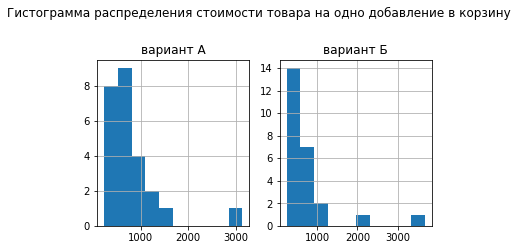

In [6]:
plt.suptitle('Гистограмма распределения стоимости товара на одно добавление в корзину', size = 12, y = 0.885) 
plt.subplots_adjust(wspace=0.2, top=0.7) 

plt.subplot(1, 2, 1)
plt.title('вариант А')
data['10 sum/cnt'].hist()

plt.subplot(1, 2, 2)
plt.title('вариант Б')
data['90 sum/cnt'].hist()

Как видно из гистограммы - наши данные с явными выбросами и не распределены нормально. Таким образом, будем использовать бутстреп для оценки различий между тестами А и Б:

In [7]:
#бутсреп
n = 3000
differences = np.empty(shape=n)
for i in range(n):
    a = np.random.choice(a=np.array(data['10 sum/cnt']), size=25)
    b = np.random.choice(a=np.array(data['90 sum/cnt']), size=25)
    diff_a_b = a.mean() - b.mean()
    differences[i] = diff_a_b

Мы получили массив значений целевой метрики (переменная differences) в результате многократных  выборок из данных. Считаем долю случаев, когда разность долей оказалась больше 85,58 (переменная diff) – значения, полученного на наших настоящих данных раньше:

In [8]:
len(differences[differences>diff])/len(differences)

0.5133333333333333

Полученное значение 0,513 это p-value. Таким образом, если нулевая гипотеза верна, то вероятность того, что при случайном извлечении выборок в А и Б тестах по 25 элементов мы получим разницу в значениях целевой метрики, равную 85.58 или выше, равна 0.513. Принимая уровень значимости 0.05, мы не сможем отвергнуть нулевую гипотезу. Значит разница между А и Б вариантами не имеет место быть, а результат в том, что использование калькулятора подбора вместо таблицы размеров позволит увеличить среднюю стоимость товаров на одно добавление на 85.58 является статистически недостоверным.